# Analysis and insights Python script: Retail market analysis in Madrid
## Part 2: Creating the data mart

### In this part we are going to:
- Access the database
- Import all the data as dataframes
- Clean each dataframe
- Create the data mart
- Save the data mart in the database

## Import the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlalchemy as sa
import folium

## Import the data

### Internal data: SQLite database

In [2]:
con = sa.create_engine("sqlite:///data/airbnb.db")

In [3]:
from sqlalchemy import inspect
insp = inspect(con)
tables = insp.get_table_names()
tables

['listings', 'listings_det']

Load all the tables

In [4]:
# We can load all the dataframes dynamically using their own names 
# with the exec function.

for table in tables:
    exec(f'{table} = pd.read_sql(table, con=con)')

In [5]:
# We can also print the dimension of each dataframe from another loop
# with the eval function, so the name of the table can be understood as an object, not like a string.

for table in tables:
    print(table + ": " + str(eval(table).shape))

listings: (20776, 19)
listings_det: (20776, 76)


### External data: Idealista web data

We don't have the property price in our dataframes, and it is one of the levers of our project. 

Then we are going to obtain that data from this webpage: [https://www.idealista.com/sala-de-prensa/informes-precio-vivienda/venta/madrid-comunidad/madrid-provincia/madrid/](https://www.idealista.com/sala-de-prensa/informes-precio-vivienda/venta/madrid-comunidad/madrid-provincia/madrid/)

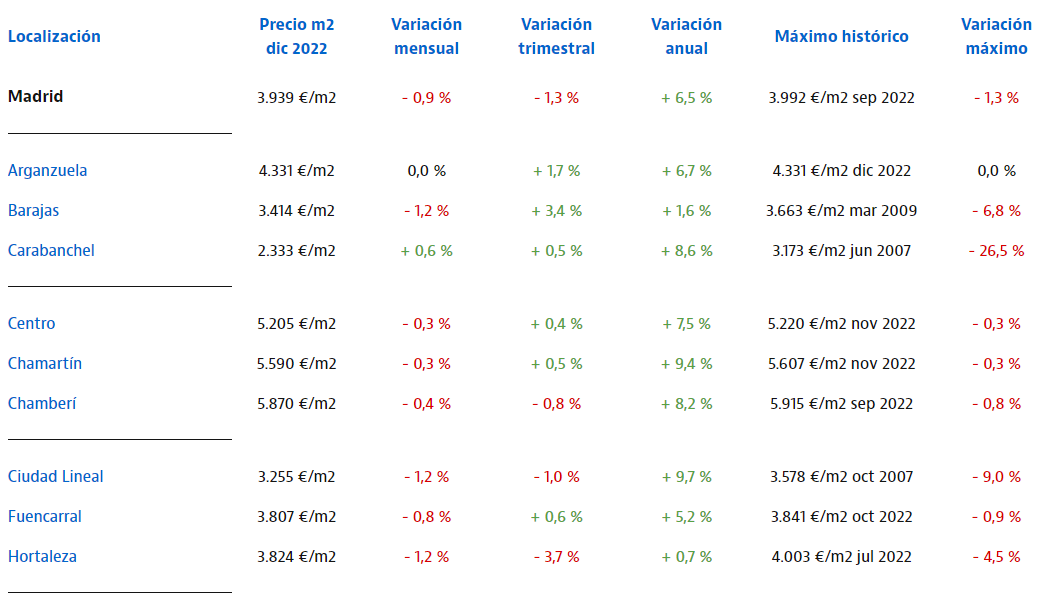

In [6]:
from IPython import display
display.Image("images/idealista_data.png")

In order to scrap the data we could inspect the HTML code and use BeatifulSoup to scrap it. However, to make the project shorter another tool is used.

Google Chrome extension "Instant Data Scraper" is used. In this way, a .csv file can be directly downloaded from the webpage in a table format.

In [7]:
pd.read_csv("data/idealista.csv")

,table__cell,table__cell 2,table__cell 3,table__cell 4,table__cell 5,table__cell 6,table__cell 7,icon-elbow,icon-elbow href
0,Madrid,3.939 €/m2,"- 0,9 %","- 1,3 %","+ 6,5 %",3.992 €/m2 sep 2022,"- 1,3 %",NaN,NaN
1,4.331 €/m2,"0,0 %","0,0 %",NaN,"+ 1,7 %",4.331 €/m2 dic 2022,"+ 6,7 %",Arganzuela,https://www.idealista.com/sala-de-prensa/infor...
2,3.414 €/m2,3.663 €/m2 mar 2009,"- 1,2 %","- 6,8 %","+ 3,4 %",NaN,"+ 1,6 %",Barajas,https://www.idealista.com/sala-de-prensa/infor...
3,2.333 €/m2,3.173 €/m2 jun 2007,"- 26,5 %","+ 8,6 %","+ 0,6 %",NaN,"+ 0,5 %",Carabanchel,https://www.idealista.com/sala-de-prensa/infor...
4,5.205 €/m2,5.220 €/m2 nov 2022,"- 0,3 %","- 0,3 %","+ 0,4 %",NaN,"+ 7,5 %",Centro,https://www.idealista.com/sala-de-prensa/infor...
5,5.590 €/m2,5.607 €/m2 nov 2022,"- 0,3 %","- 0,3 %","+ 0,5 %",NaN,"+ 9,4 %",Chamartín,https://www.idealista.com/sala-de-prensa/infor...
6,5.870 €/m2,5.915 €/m2 sep 2022,"- 0,4 %","- 0,8 %","+ 8,2 %",NaN,"- 0,8 %",Chamberí,https://www.idealista.com/sala-de-prensa/infor...
7,3.255 €/m2,3.578 €/m2 oct 2007,"- 1,2 %","- 1,0 %","+ 9,7 %",NaN,"- 9,0 %",Ciudad Lineal,https://www.idealista.com/sala-de-prensa/infor...
8,3.807 €/m2,3.841 €/m2 oct 2022,"- 0,8 %","- 0,9 %","+ 0,6 %",NaN,"+ 5,2 %",Fuencarral,https://www.idealista.com/sala-de-prensa/infor...
9,3.824 €/m2,4.003 €/m2 jul 2022,"- 1,2 %","- 3,7 %","+ 0,7 %",NaN,"- 4,5 %",Hortaleza,https://www.idealista.com/sala-de-prensa/infor...


In [8]:
price_m2 = pd.read_csv("data/idealista.csv").loc[1:,["table__cell","icon-elbow"]].rename(columns={"table__cell": "price_m2", "icon-elbow":"neighbourhood_group"})
price_m2.head()

,price_m2,neighbourhood_group
1,4.331 €/m2,Arganzuela
2,3.414 €/m2,Barajas
3,2.333 €/m2,Carabanchel
4,5.205 €/m2,Centro
5,5.590 €/m2,Chamartín


We need to clean the "price_m2" feature.

In [9]:
price_m2["price_m2"] = price_m2["price_m2"].apply(lambda x: x.split(" ")[0].replace(".","")).astype("int")
price_m2.head()

,price_m2,neighbourhood_group
1,4331,Arganzuela
2,3414,Barajas
3,2333,Carabanchel
4,5205,Centro
5,5590,Chamartín


## Cleaning the data
### listings dataframe

In [10]:
listings.head()

,index,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,0,6369,"Rooftop terrace room , ensuite bathroom",13660,Simon,Chamartín,Hispanoamérica,40.45724,-3.67688,Private room,90,4,102,2022-11-29,0.66,1,61,18,None
1,1,21853,Bright and airy room,83531,Abdel,Latina,Cármenes,40.40381,-3.74130,Private room,31,4,33,2018-07-15,0.33,2,346,0,None
2,2,24805,Gran Via Studio Madrid,346366726,Alvaro,Centro,Universidad,40.42183,-3.70529,Entire home/apt,92,5,25,2022-10-16,0.26,1,73,10,None
3,3,26825,Single Room whith private Bathroom,114340,Agustina,Arganzuela,Legazpi,40.38975,-3.69018,Private room,29,2,173,2022-11-23,1.13,1,345,19,None
4,4,37921,Piso barrio de salamanca,162926,Sergio,Salamanca,Recoletos,40.42325,-3.68281,Private room,20,3,0,None,NaN,1,291,0,None


In [11]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20776 entries, 0 to 20775
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   index                           20776 non-null  int64  
 1   id                              20776 non-null  int64  
 2   name                            20772 non-null  object 
 3   host_id                         20776 non-null  int64  
 4   host_name                       20773 non-null  object 
 5   neighbourhood_group             20776 non-null  object 
 6   neighbourhood                   20776 non-null  object 
 7   latitude                        20776 non-null  float64
 8   longitude                       20776 non-null  float64
 9   room_type                       20776 non-null  object 
 10  price                           20776 non-null  int64  
 11  minimum_nights                  20776 non-null  int64  
 12  number_of_reviews               

#### Variables and data types

We are going to remove all the features we don't need for this project. 

In [12]:
to_remove = ['index',
              'host_name',
              'number_of_reviews',
              'last_review',
              'reviews_per_month',
              'calculated_host_listings_count',
              'number_of_reviews_ltm',
              'license'
             ]

listings.drop(columns=to_remove, inplace=True)
listings.head()

,id,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,availability_365
0,6369,"Rooftop terrace room , ensuite bathroom",13660,Chamartín,Hispanoamérica,40.45724,-3.67688,Private room,90,4,61
1,21853,Bright and airy room,83531,Latina,Cármenes,40.40381,-3.74130,Private room,31,4,346
2,24805,Gran Via Studio Madrid,346366726,Centro,Universidad,40.42183,-3.70529,Entire home/apt,92,5,73
3,26825,Single Room whith private Bathroom,114340,Arganzuela,Legazpi,40.38975,-3.69018,Private room,29,2,345
4,37921,Piso barrio de salamanca,162926,Salamanca,Recoletos,40.42325,-3.68281,Private room,20,3,291


Check the data types

In [13]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20776 entries, 0 to 20775
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   20776 non-null  int64  
 1   name                 20772 non-null  object 
 2   host_id              20776 non-null  int64  
 3   neighbourhood_group  20776 non-null  object 
 4   neighbourhood        20776 non-null  object 
 5   latitude             20776 non-null  float64
 6   longitude            20776 non-null  float64
 7   room_type            20776 non-null  object 
 8   price                20776 non-null  int64  
 9   minimum_nights       20776 non-null  int64  
 10  availability_365     20776 non-null  int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 1.7+ MB


Conclusion: change the object dtypes to categorical

In [14]:
for i in listings.select_dtypes("object").columns.to_list():
    listings[i] = listings[i].astype("category")

In [15]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20776 entries, 0 to 20775
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   id                   20776 non-null  int64   
 1   name                 20772 non-null  category
 2   host_id              20776 non-null  int64   
 3   neighbourhood_group  20776 non-null  category
 4   neighbourhood        20776 non-null  category
 5   latitude             20776 non-null  float64 
 6   longitude            20776 non-null  float64 
 7   room_type            20776 non-null  category
 8   price                20776 non-null  int64   
 9   minimum_nights       20776 non-null  int64   
 10  availability_365     20776 non-null  int64   
dtypes: category(4), float64(2), int64(5)
memory usage: 1.9 MB


#### Nulls analysis

In [16]:
listings.isna().sum()

id                     0
name                   4
host_id                0
neighbourhood_group    0
neighbourhood          0
latitude               0
longitude              0
room_type              0
price                  0
minimum_nights         0
availability_365       0
dtype: int64

We see there are 4 null values from the variable name

In [17]:
listings[listings["name"].isna()]

,id,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,availability_365
1054,6247825,NaN,30360739,Fuencarral - El Pardo,La Paz,40.48610,-3.70858,Entire home/apt,80,6,345
1242,7164589,NaN,37525983,Centro,Palacio,40.41458,-3.71422,Private room,30,1,0
1946,11687495,NaN,48387429,San Blas - Canillejas,Simancas,40.43765,-3.62672,Entire home/apt,50,1,0
2282,13585476,NaN,20922102,Centro,Universidad,40.42718,-3.71144,Entire home/apt,65,3,0


In this case the name of the host is not relevant for the analysis. Then, it is not gonna be changed.

#### Duplicate analysis

In [18]:
listings.duplicated().sum()

0

#### Categorical dtypes analysis
We are going to check the values and frequencies of the categorical variables.

In this case, the variable "name" is not analysed since it is not relevant for the project.

In [21]:
listings["neighbourhood"].value_counts()

Embajadores      2523
Universidad      1964
Palacio          1679
Sol              1209
Justicia         1051
                 ... 
Amposta             8
Pavones             7
Valdemarín          5
El Pardo            1
Fuentelareina       1
Name: neighbourhood, Length: 126, dtype: int64

In [22]:
listings["neighbourhood_group"].value_counts()

Centro                   9365
Salamanca                1422
Chamberí                 1261
Arganzuela               1080
Tetuán                    993
Retiro                    749
Carabanchel               734
Ciudad Lineal             645
Moncloa - Aravaca         604
Chamartín                 604
Puente de Vallecas        568
Latina                    556
San Blas - Canillejas     473
Hortaleza                 448
Usera                     354
Fuencarral - El Pardo     285
Villaverde                179
Barajas                   161
Moratalaz                 137
Villa de Vallecas          95
Vicálvaro                  63
Name: neighbourhood_group, dtype: int64

In [23]:
listings["room_type"].value_counts()

Entire home/apt    13251
Private room        7112
Shared room          282
Hotel room           131
Name: room_type, dtype: int64

Among the room types, there are hotels. Our company is not interested in buying hotels, so we are going to remove those records.

In [24]:
listings = listings.query('room_type != "Hotel room"')

In [25]:
listings["room_type"].value_counts()

Entire home/apt    13251
Private room        7112
Shared room          282
Hotel room             0
Name: room_type, dtype: int64

#### Numerical dtypes analysis
Here we are going to analyse from "price" to "availability_365".

In [26]:
listings.iloc[:,7:].describe().T

,count,mean,std,min,25%,50%,75%,max
price,20645.0,160.521385,1243.942473,8.0,49.0,83.0,130.0,95150.0
minimum_nights,20645.0,7.316832,33.119230,1.0,1.0,2.0,3.0,1125.0
availability_365,20645.0,167.603633,140.613446,0.0,15.0,157.0,323.0,365.0


Conclusions: 
- We need to check "price" maximum and minimum values
- In "minimum_nights" we have to check its maximum value

Check maximum and minimum values of "price".

<AxesSubplot:ylabel='Density'>

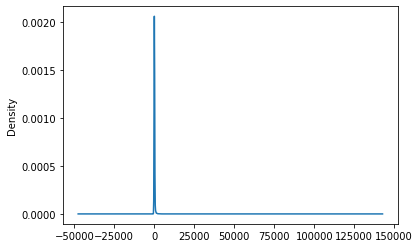

In [27]:
listings["price"].plot(kind="kde")

We can see most values are concentrated around zero according to the scale of the plot. Then, let's check those outliers.

Let's plot how many properties are rented for a price higher than 1000€.

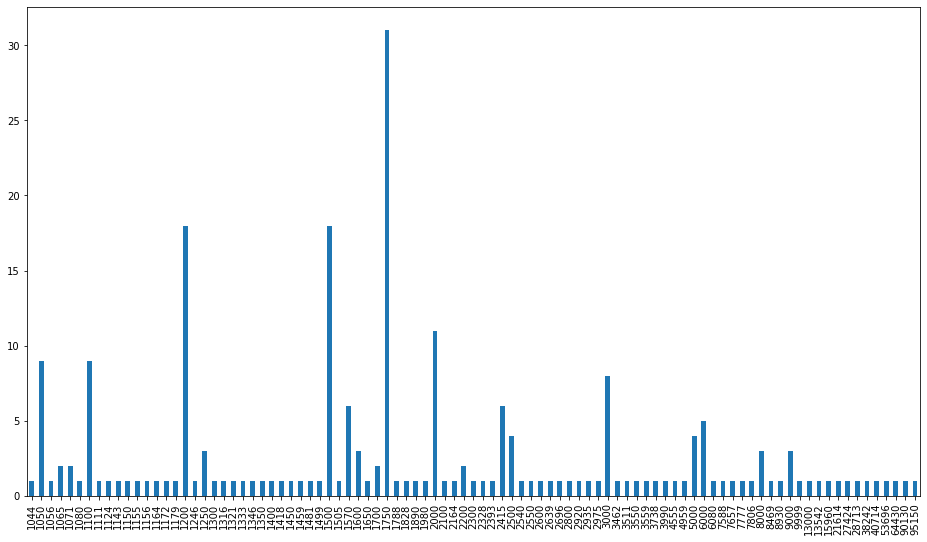

In [28]:
plt.figure(figsize=(16,9))
listings[listings["price"] > 1000]["price"].value_counts().sort_index().plot(kind="bar")
plt.xticks(size = 10);

Conclusion:
- The data do not indicate any error value inside the dataset, as it could be 99999€ for example. Then we are not going to change any value here.

Checking the minimum values for "price":

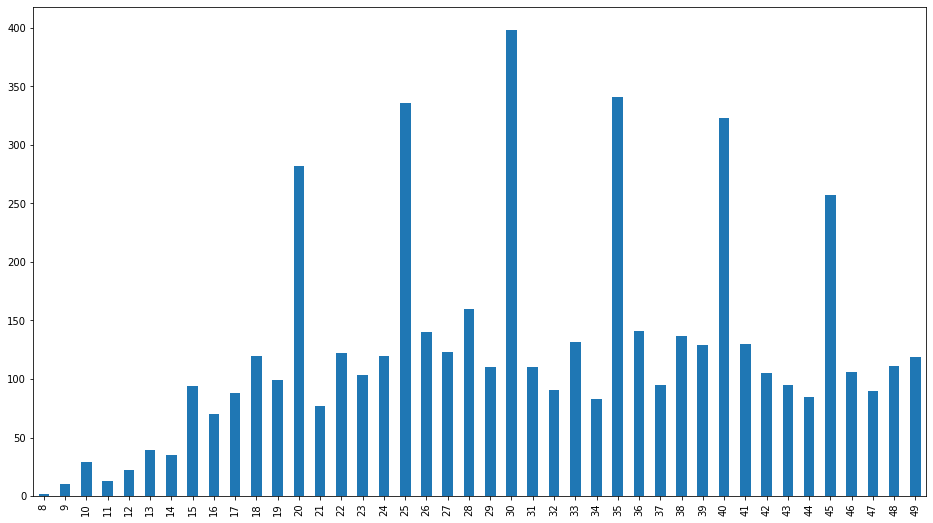

In [29]:
plt.figure(figsize=(16,9))
listings[listings["price"] < 50]["price"].value_counts().sort_index().plot(kind="bar")
plt.xticks(size = 10);

There is a high frequency of values for 20€. Below that it is going to be difficult to obtain any revenue. Then we are going to discard any property below 20€.

In [30]:
listings = listings[listings["price"] >= 20]

Check maximum values of "minimum_nights".

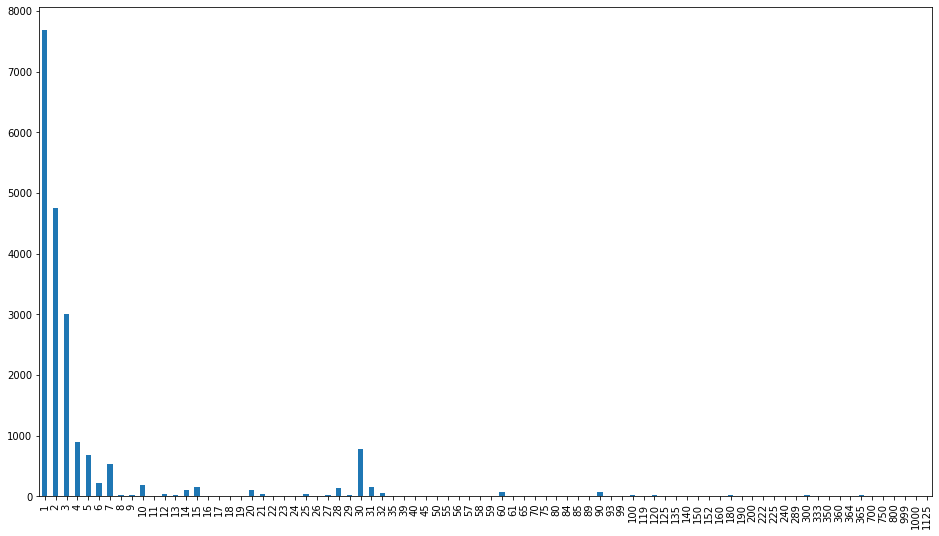

In [31]:
plt.figure(figsize=(16,9))
listings[listings["minimum_nights"] >= 0]["minimum_nights"].value_counts().sort_index().plot.bar();

Conclusion:
- Most properties require 1 minimum night.
- There are minimum night requirements up to 1125 nights. 

Since the company is interested in touristic apartments, the maximum allowed stay in a property is assumed to be 30 days. Then, all properties with a minimum night requirement higher than 30 are going to be discarded.

In [32]:
listings = listings.query('minimum_nights <= 30')

After checking the numerical dtypes, the summary is the following:

In [33]:
listings.iloc[:,7:].describe().T

,count,mean,std,min,25%,50%,75%,max
price,19472.0,164.375205,1273.943978,20.0,50.0,85.0,132.0,95150.0
minimum_nights,19472.0,3.991578,6.534464,1.0,1.0,2.0,3.0,30.0
availability_365,19472.0,169.613702,140.561227,0.0,20.0,159.0,325.0,365.0


The are still some outliers that distorts the mean for the numerical data types. 

Then, it is going to be considered the median instead of the mean when analysing the data in later sections.

### listings_det dataframe

In [34]:
listings_det.head()

,index,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,0,6369,https://www.airbnb.com/rooms/6369,20221213034110,2022-12-13,city scrape,"Rooftop terrace room , ensuite bathroom",Excellent connection with the AIRPORT and EXHI...,None,https://a0.muscache.com/pictures/683224/4cc318...,...,4.86,4.83,4.86,None,f,1,0,1,0,0.66
1,1,21853,https://www.airbnb.com/rooms/21853,20221213034110,2022-12-13,city scrape,Bright and airy room,We have a quiet and sunny room with a good vie...,We live in a leafy neighbourhood with plenty o...,https://a0.muscache.com/pictures/68483181/87bc...,...,4.82,4.21,4.67,None,f,2,0,2,0,0.33
2,2,24805,https://www.airbnb.com/rooms/24805,20221213034110,2022-12-13,city scrape,Gran Via Studio Madrid,"Studio located 50 meters from Gran Via, next t...","The area is next to the Gran Via, so people li...",https://a0.muscache.com/pictures/miso/Hosting-...,...,5.00,5.00,4.80,None,f,1,1,0,0,0.26
3,3,30959,https://www.airbnb.com/rooms/30959,20221213034110,2022-12-13,previous scrape,Beautiful loft in Madrid Center,Beautiful Loft 60m2 size just in the historica...,None,https://a0.muscache.com/pictures/78173471/835e...,...,4.63,4.88,4.25,None,f,1,1,0,0,0.09
4,4,37921,https://www.airbnb.com/rooms/37921,20221213034110,2022-12-13,city scrape,Piso barrio de salamanca,<b>The space</b><br />Piso de 3 habitaciones y...,None,https://a0.muscache.com/pictures/0fcae836-71d3...,...,NaN,NaN,NaN,None,f,1,0,1,0,NaN


In [35]:
listings_det.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20776 entries, 0 to 20775
Data columns (total 76 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   index                                         20776 non-null  int64  
 1   id                                            20776 non-null  int64  
 2   listing_url                                   20776 non-null  object 
 3   scrape_id                                     20776 non-null  int64  
 4   last_scraped                                  20776 non-null  object 
 5   source                                        20776 non-null  object 
 6   name                                          20772 non-null  object 
 7   description                                   20117 non-null  object 
 8   neighborhood_overview                         11429 non-null  object 
 9   picture_url                                   20775 non-null 

#### Variables and data types

We are going to use the variables that can provide any relevant information for the current project.

In [36]:
to_keep = ['id',
              'description',
              'host_is_superhost',
              'accommodates',
              'bathrooms',
              'bedrooms',
              'beds',
              'number_of_reviews',
              'review_scores_rating',
              'review_scores_communication',
              'review_scores_location'
             ]

listings_det = listings_det.loc[:, to_keep]

Check the data types

In [37]:
listings_det.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20776 entries, 0 to 20775
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           20776 non-null  int64  
 1   description                  20117 non-null  object 
 2   host_is_superhost            20770 non-null  object 
 3   accommodates                 20776 non-null  int64  
 4   bathrooms                    0 non-null      float64
 5   bedrooms                     19260 non-null  float64
 6   beds                         20471 non-null  float64
 7   number_of_reviews            20776 non-null  int64  
 8   review_scores_rating         16649 non-null  float64
 9   review_scores_communication  16508 non-null  float64
 10  review_scores_location       16505 non-null  float64
dtypes: float64(6), int64(3), object(2)
memory usage: 1.7+ MB


Conclusion: set "host_is_superhost" as categorical dtype

In [38]:
listings_det["host_is_superhost"] = listings_det["host_is_superhost"].astype("category")

#### Nulls analysis

In [39]:
listings_det.isna().sum()

id                                 0
description                      659
host_is_superhost                  6
accommodates                       0
bathrooms                      20776
bedrooms                        1516
beds                             305
number_of_reviews                  0
review_scores_rating            4127
review_scores_communication     4268
review_scores_location          4271
dtype: int64

Conclusions:
- "description" is not relevant, so we can leave it as it is.
- "host_is_superhost" has very few nulls, so we can also leave it as it is.
- "bathrooms" is completely full of nulls. We are going to discard it.
- "bedrooms" is relevant for the project. We can replace the nulls using variables like "accommodates" or "beds"
- "beds" can be obtained from "accommodates" variable

Let's see if we can make a good guess for "beds" variable from "accommodates"

In [40]:
pd.crosstab(listings_det["beds"], listings_det["accommodates"])

accommodates,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
beds,,,,,,,,,,,,,,,,
1.0,2913,5984,445,661,16,17,2,4,0,4,0,0,0,0,0,1
2.0,133,1097,1210,2765,120,140,1,6,0,0,0,0,0,0,0,1
3.0,20,69,252,1042,472,686,28,17,0,3,0,0,0,0,0,0
4.0,19,24,21,267,225,557,90,119,10,8,0,1,0,0,0,0
5.0,6,3,3,22,49,171,75,123,16,29,7,3,0,0,0,0
6.0,10,5,0,8,6,50,22,67,12,23,6,12,0,1,0,0
7.0,0,0,1,1,2,9,15,18,14,24,5,8,1,4,0,0
8.0,17,7,3,0,2,3,0,21,2,16,2,4,3,1,0,2
9.0,0,0,0,0,0,0,0,4,4,5,1,7,1,0,2,1


Apparently we can assume the number of beds from the number of accommodates. By reading the crosstab we can see that:
- One or two people can be associated to one bed
- Three or four people can be associated to two beds
- Five or six people can be associated to three beds
- For more than 6 people we are going to assign four beds

Check the amount of nulls and the frequency of all values

In [41]:
listings_det["beds"].value_counts(dropna=False).sort_index()

1.0     10047
2.0      5473
3.0      2589
4.0      1341
5.0       507
6.0       222
7.0       102
8.0        83
9.0        25
10.0       45
11.0        8
12.0        7
13.0        4
14.0        8
15.0        1
16.0        4
17.0        2
23.0        1
30.0        1
40.0        1
NaN       305
Name: beds, dtype: int64

We are going to define a function for assigning the missing beds values according to the number of accommodates as we just defined.

In [42]:
def change_nulls(record):
    # List of conditions
    conditions = [(record["accommodates"] <= 2),
                (record["accommodates"] > 2) & (record["accommodates"] <= 4),
                (record["accommodates"] > 4) & (record["accommodates"] <= 6),
                (record["accommodates"] > 6)]
    
    # List of results
    results = [1,2,3,4,]

    # Output
    return(np.select(conditions, results, default=-999))

# Applying the fuction to the nulls values of "beds"
listings_det.loc[listings_det["beds"].isna(),"beds"] = listings_det[listings_det["beds"].isna()].apply(change_nulls, axis=1).astype('float64')


Now we can check if the changes have been applied and how the new value counts distribution is very different from the original one.

In [43]:
listings_det["beds"].value_counts(dropna=False).sort_index()

1.0     10296
2.0      5514
3.0      2599
4.0      1346
5.0       507
6.0       222
7.0       102
8.0        83
9.0        25
10.0       45
11.0        8
12.0        7
13.0        4
14.0        8
15.0        1
16.0        4
17.0        2
23.0        1
30.0        1
40.0        1
Name: beds, dtype: int64

Let's see if we can also guess the number of bedrooms according to the number of accommodates.

In [44]:
pd.crosstab(listings_det["bedrooms"], listings_det["accommodates"])

accommodates,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
bedrooms,,,,,,,,,,,,,,,,
1.0,2948,6217,1271,2447,128,102,10,19,0,8,1,2,0,0,0,2
2.0,84,178,427,1942,494,873,41,52,5,7,5,1,0,1,0,0
3.0,36,32,41,139,247,609,133,200,14,19,5,10,2,2,0,0
4.0,15,15,1,16,17,37,43,101,28,49,8,10,2,2,2,1
5.0,7,5,2,1,3,3,2,10,7,33,2,12,1,2,3,12
6.0,3,1,0,0,0,2,0,2,3,3,1,5,3,0,4,2
7.0,0,0,0,0,0,0,0,1,1,0,0,0,0,2,0,6
8.0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,4
9.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


The correlation between bedrooms and accommodates is not so straight forward. 

Let's compare beds and bedrooms.

In [45]:
pd.crosstab(listings_det["bedrooms"], listings_det["beds"])

beds,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,23.0,30.0,40.0
bedrooms,,,,,,,,,,,,,,,,,,,,
1.0,9072,3346,445,168,22,32,4,38,0,22,0,3,0,1,0,0,0,0,1,1
2.0,141,1694,1545,579,100,39,9,3,0,0,0,0,0,0,0,0,0,0,0,0
3.0,56,26,541,469,276,68,30,13,5,1,2,1,1,0,0,0,0,0,0,0
4.0,26,4,6,105,81,56,41,12,6,6,2,2,0,0,0,0,0,0,0,0
5.0,12,0,1,1,22,15,14,13,10,11,3,0,2,0,0,1,0,0,0,0
6.0,4,0,0,0,0,10,0,4,3,4,1,1,0,1,0,1,0,0,0,0
7.0,0,0,0,0,0,0,3,0,0,0,0,0,1,3,1,1,1,0,0,0
8.0,3,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0
9.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


The correlation seems to be more clear here.

Conclusions:
- One or two beds usually correspond to one bedroom.
- Three or four beds usually corresponds with two bedrooms.
- Five or six beds usually correspond to three bedrooms.
- For more than six beds we are going to assign four bedrooms.

We are going to follow the same exact procedure we did with beds nulls analysis.

Check the amount of nulls and the frequency of all values

In [46]:
listings_det["bedrooms"].value_counts(dropna=False).sort_index()

1.0     13155
2.0      4110
3.0      1489
4.0       347
5.0       105
6.0        29
7.0        10
8.0         7
9.0         2
14.0        3
15.0        1
17.0        1
18.0        1
NaN      1516
Name: bedrooms, dtype: int64

Apply the same function to change nulls for bedrooms analysis.

In [47]:
def change_nulls(record):
    # List of conditions
    conditions = [(record["beds"] <= 2),
                (record["beds"] > 2) & (record["beds"] <= 4),
                (record["beds"] > 4) & (record["beds"] <= 6),
                (record["beds"] > 6)]
    
    # List of results
    results = [1,2,3,4]

    # Output
    return(np.select(conditions, results, default=-999))

# Applying the fuction to the nulls values of "bedrooms"
listings_det.loc[listings_det["bedrooms"].isna(),"bedrooms"] = listings_det[listings_det["bedrooms"].isna()].apply(change_nulls, axis=1).astype('float64')

We can check how the changes have been applied.

In [48]:
listings_det["bedrooms"].value_counts(dropna=False).sort_index()

1.0     14577
2.0      4195
3.0      1497
4.0       348
5.0       105
6.0        29
7.0        10
8.0         7
9.0         2
14.0        3
15.0        1
17.0        1
18.0        1
Name: bedrooms, dtype: int64

Last but not least, we are going to remove the variable "bathrooms".

In [49]:
listings_det.drop(columns="bathrooms", inplace=True)
listings_det.head()

,id,description,host_is_superhost,accommodates,bedrooms,beds,number_of_reviews,review_scores_rating,review_scores_communication,review_scores_location
0,6369,Excellent connection with the AIRPORT and EXHI...,t,2,1.0,1.0,102,4.87,4.86,4.83
1,21853,We have a quiet and sunny room with a good vie...,f,1,1.0,1.0,33,4.58,4.82,4.21
2,24805,"Studio located 50 meters from Gran Via, next t...",f,3,1.0,1.0,25,4.88,5.00,5.00
3,30959,Beautiful Loft 60m2 size just in the historica...,f,2,1.0,1.0,8,4.38,4.63,4.88
4,37921,<b>The space</b><br />Piso de 3 habitaciones y...,f,8,3.0,6.0,0,NaN,NaN,NaN


### Duplicate analysis

In [50]:
listings_det.duplicated().sum()

0

In [51]:
listings_det.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20776 entries, 0 to 20775
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   id                           20776 non-null  int64   
 1   description                  20117 non-null  object  
 2   host_is_superhost            20770 non-null  category
 3   accommodates                 20776 non-null  int64   
 4   bedrooms                     20776 non-null  float64 
 5   beds                         20776 non-null  float64 
 6   number_of_reviews            20776 non-null  int64   
 7   review_scores_rating         16649 non-null  float64 
 8   review_scores_communication  16508 non-null  float64 
 9   review_scores_location       16505 non-null  float64 
dtypes: category(1), float64(5), int64(3), object(1)
memory usage: 1.4+ MB


#### Categorical dtypes analysis

Let's analyse the values and the frequencies of each categorical dtype.

In [52]:
listings_det["host_is_superhost"].value_counts()

f    16774
t     3996
Name: host_is_superhost, dtype: int64

#### Numerical dtypes analysis


In [53]:
listings_det.describe(include = "number").T

,count,mean,std,min,25%,50%,75%,max
id,20776.0,1.915951e+17,3.056442e+17,6369.0,23484724.50,41222286.50,5.825072e+17,7.805076e+17
accommodates,20776.0,3.143242e+00,1.929238e+00,0.0,2.00,2.00,4.000000e+00,1.600000e+01
bedrooms,20776.0,1.433625e+00,8.177475e-01,1.0,1.00,1.00,2.000000e+00,1.800000e+01
beds,20776.0,1.971843e+00,1.439958e+00,1.0,1.00,2.00,2.000000e+00,4.000000e+01
number_of_reviews,20776.0,4.144426e+01,7.672465e+01,0.0,1.00,10.00,4.500000e+01,8.700000e+02
review_scores_rating,16649.0,4.593821e+00,6.311590e-01,0.0,4.50,4.75,4.910000e+00,5.000000e+00
review_scores_communication,16508.0,4.760850e+00,4.334594e-01,1.0,4.71,4.89,5.000000e+00,5.000000e+00
review_scores_location,16505.0,4.775254e+00,3.727693e-01,1.0,4.70,4.90,5.000000e+00,5.000000e+00


There is nothing strange. 

Quality problems for numerical dtypes have already been solved, so we can proceed to create the data mart by joining both tables.

## Creating the data mart

We are going to join the two tables:
- listings
- listings_det

The main table will be "listings" and the field "id" will be used to join both tables.

On the other hand, there's also the "price_m2" table, that will join the other two by the field "neighbourhood_group". First, we need to check that "price_m2" and listings common variable names are the same. Then, we will have to check that.

First, let's join the main listings tables. The resulting table will have the same records as "listings" and a number of columns equal to the sum of both tables minus one, the id field will be the same for both tables.

In [54]:
listings.shape

(19472, 11)

In [55]:
listings_det.shape

(20776, 10)

The resulting table should have 19472 rows and 20 columns.

In [56]:
df = pd.merge(left=listings, right=listings_det, how="left", on="id")
df

,id,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,availability_365,description,host_is_superhost,accommodates,bedrooms,beds,number_of_reviews,review_scores_rating,review_scores_communication,review_scores_location
0,6369,"Rooftop terrace room , ensuite bathroom",13660,Chamartín,Hispanoamérica,40.457240,-3.676880,Private room,90,4,61,Excellent connection with the AIRPORT and EXHI...,t,2,1.0,1.0,102,4.87,4.86,4.83
1,21853,Bright and airy room,83531,Latina,Cármenes,40.403810,-3.741300,Private room,31,4,346,We have a quiet and sunny room with a good vie...,f,1,1.0,1.0,33,4.58,4.82,4.21
2,24805,Gran Via Studio Madrid,346366726,Centro,Universidad,40.421830,-3.705290,Entire home/apt,92,5,73,"Studio located 50 meters from Gran Via, next t...",f,3,1.0,1.0,25,4.88,5.00,5.00
3,26825,Single Room whith private Bathroom,114340,Arganzuela,Legazpi,40.389750,-3.690180,Private room,29,2,345,Nice and cozy roon for one person with a priva...,t,1,1.0,1.0,173,4.70,4.71,4.74
4,37921,Piso barrio de salamanca,162926,Salamanca,Recoletos,40.423250,-3.682810,Private room,20,3,291,<b>The space</b><br />Piso de 3 habitaciones y...,f,8,3.0,6.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19467,779864034353423768,Habitación individual y baño,82781578,Barajas,Aeropuerto,40.454986,-3.584427,Private room,42,1,365,Cercano al aeropuerto y principales salidas/en...,f,2,1.0,1.0,0,NaN,NaN,NaN
19468,780168420093352936,Visit Central Madrid w/ Friends & Family !,413881187,Centro,Embajadores,40.410884,-3.702173,Entire home/apt,112,1,28,FREE CLEANING FEE :)<br /><br />Amazing brand ...,f,4,2.0,2.0,0,NaN,NaN,NaN
19469,780281142182756633,Apartamento Plaza De Castilla M (CAS224),460712642,Chamartín,Castilla,40.469088,-3.687143,Entire home/apt,117,1,20,"Brand new, quiet and with everything you need!...",f,6,2.0,3.0,0,NaN,NaN,NaN
19470,780325020069234563,Mit House Rubik I en Madrid,377605855,Ciudad Lineal,Pueblo Nuevo,40.434037,-3.639478,Entire home/apt,75,1,68,"Renovated, cozy and well used <br />Pueblo Nue...",f,3,1.0,2.0,0,NaN,NaN,NaN


Let's proceed with joining price_m2 to df.

First let's check the field we want to join them both have the same values, so we can actually join them.

For the external data set of "price_m2":

In [57]:
price_m2["neighbourhood_group"].unique().shape

(21,)

For the data set "df":

In [58]:
df["neighbourhood_group"].unique().shape

(21,)

They have the same number of neighbourhood groups. Let's see they have the same lables.

In [59]:
pd.Series(price_m2["neighbourhood_group"].unique()).sort_values().to_numpy()

array(['Arganzuela', 'Barajas', 'Carabanchel', 'Centro', 'Chamartín',
       'Chamberí', 'Ciudad Lineal', 'Fuencarral', 'Hortaleza', 'Latina',
       'Moncloa', 'Moratalaz', 'Puente de Vallecas', 'Retiro',
       'Salamanca', 'San Blas', 'Tetuán', 'Usera', 'Vicálvaro',
       'Villa de Vallecas', 'Villaverde'], dtype=object)

In [60]:
pd.Series(df["neighbourhood_group"].unique().categories).sort_values().to_numpy()

array(['Arganzuela', 'Barajas', 'Carabanchel', 'Centro', 'Chamartín',
       'Chamberí', 'Ciudad Lineal', 'Fuencarral - El Pardo', 'Hortaleza',
       'Latina', 'Moncloa - Aravaca', 'Moratalaz', 'Puente de Vallecas',
       'Retiro', 'Salamanca', 'San Blas - Canillejas', 'Tetuán', 'Usera',
       'Vicálvaro', 'Villa de Vallecas', 'Villaverde'], dtype=object)

There are some neighbourhood groups which are not labeled in the same way.
- Fuencarral - El Pardo
- Moncloa - Aravaca
- San Blas - Canillejas

Let's fix this by changing the label in "price_m2" data frame.

In [61]:
price_m2["neighbourhood_group"] = price_m2["neighbourhood_group"].map(
                            {"Fuencarral":"Fuencarral - El Pardo", "Moncloa":"Moncloa - Aravaca", "San Blas":"San Blas - Canillejas"}) \
                            .fillna(price_m2["neighbourhood_group"])

We can join both dataframes.

In [62]:
df = pd.merge(left = df, right = price_m2, how = "left", left_on = "neighbourhood_group", right_on = "neighbourhood_group")
df

,id,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,...,description,host_is_superhost,accommodates,bedrooms,beds,number_of_reviews,review_scores_rating,review_scores_communication,review_scores_location,price_m2
0,6369,"Rooftop terrace room , ensuite bathroom",13660,Chamartín,Hispanoamérica,40.457240,-3.676880,Private room,90,4,...,Excellent connection with the AIRPORT and EXHI...,t,2,1.0,1.0,102,4.87,4.86,4.83,5590
1,21853,Bright and airy room,83531,Latina,Cármenes,40.403810,-3.741300,Private room,31,4,...,We have a quiet and sunny room with a good vie...,f,1,1.0,1.0,33,4.58,4.82,4.21,2476
2,24805,Gran Via Studio Madrid,346366726,Centro,Universidad,40.421830,-3.705290,Entire home/apt,92,5,...,"Studio located 50 meters from Gran Via, next t...",f,3,1.0,1.0,25,4.88,5.00,5.00,5205
3,26825,Single Room whith private Bathroom,114340,Arganzuela,Legazpi,40.389750,-3.690180,Private room,29,2,...,Nice and cozy roon for one person with a priva...,t,1,1.0,1.0,173,4.70,4.71,4.74,4331
4,37921,Piso barrio de salamanca,162926,Salamanca,Recoletos,40.423250,-3.682810,Private room,20,3,...,<b>The space</b><br />Piso de 3 habitaciones y...,f,8,3.0,6.0,0,NaN,NaN,NaN,6633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19467,779864034353423768,Habitación individual y baño,82781578,Barajas,Aeropuerto,40.454986,-3.584427,Private room,42,1,...,Cercano al aeropuerto y principales salidas/en...,f,2,1.0,1.0,0,NaN,NaN,NaN,3414
19468,780168420093352936,Visit Central Madrid w/ Friends & Family !,413881187,Centro,Embajadores,40.410884,-3.702173,Entire home/apt,112,1,...,FREE CLEANING FEE :)<br /><br />Amazing brand ...,f,4,2.0,2.0,0,NaN,NaN,NaN,5205
19469,780281142182756633,Apartamento Plaza De Castilla M (CAS224),460712642,Chamartín,Castilla,40.469088,-3.687143,Entire home/apt,117,1,...,"Brand new, quiet and with everything you need!...",f,6,2.0,3.0,0,NaN,NaN,NaN,5590
19470,780325020069234563,Mit House Rubik I en Madrid,377605855,Ciudad Lineal,Pueblo Nuevo,40.434037,-3.639478,Entire home/apt,75,1,...,"Renovated, cozy and well used <br />Pueblo Nue...",f,3,1.0,2.0,0,NaN,NaN,NaN,3255


Check that there are no nulls on "price_m2" variable to check the joining was successful.

In [63]:
df["price_m2"].isna().sum()

0

## Saving the data in the database

In order to keep the work saved in the database (so we don't have to repeat all the work again), we load the dataframe df into the airbnb.db file.

In [64]:
df.to_sql("df", con = con, if_exists = "replace")